# Albatross Usage Information

_Before using this notebook, make sure to follow the [installation](https://github.com/camirmas/albatross#installation) instructions._

**Full installation and module documentation can be found at https://albatross-wind.readthedocs.io/en/latest/index.html**

In [1]:
from albatross.requests import get_regions, request_wtk_point_data, build_wtk_filepath, identify_regions
from albatross.analysis import boxplot, get_diurnal_stats, plot_diurnal_stats, plot_windrose, pdf, turbulence_std
from albatross import WindTurbine, RequestParams

## The `requests` module

This module is responsible for retrieving WIND Toolkit data.

Full documentation can be found at https://albatross-wind.readthedocs.io/en/latest/requests.html

`get_regions` returns the full set of available regions with their configuration options. Its optional argument determines whether to pretty print the results alongside returning them.

In [2]:
get_regions(True)

{
   "bangladesh": {
      "year_range": [
         2014,
         2017
      ],
      "resolutions": [
         "hourly"
      ],
      "lat_lon_range": [
         [
            20.63102,
            28.500214
         ],
         [
            85.809204,
            93.72342
         ]
      ]
   },
   "canada": {
      "year_range": [
         2007,
         2014
      ],
      "resolutions": [
         "hourly",
         "5min"
      ],
      "lat_lon_range": [
         [
            40.0522,
            68.10168
         ],
         [
            -144.3318,
            -40.799896
         ]
      ]
   },
   "central_asia": {
      "year_range": [
         2015,
         2015
      ],
      "resolutions": [
         "hourly"
      ],
      "lat_lon_range": [
         [
            35.184048,
            55.425625
         ],
         [
            46.519226,
            87.2984
         ]
      ]
   },
   "conus": {
      "year_range": [
         2007,
         2014
      ],
      

{'bangladesh': {'year_range': [2014, 2017],
  'resolutions': ['hourly'],
  'lat_lon_range': [[20.63102, 28.500214], [85.809204, 93.72342]]},
 'canada': {'year_range': [2007, 2014],
  'resolutions': ['hourly', '5min'],
  'lat_lon_range': [[40.0522, 68.10168], [-144.3318, -40.799896]]},
 'central_asia': {'year_range': [2015, 2015],
  'resolutions': ['hourly'],
  'lat_lon_range': [[35.184048, 55.425625], [46.519226, 87.2984]]},
 'conus': {'year_range': [2007, 2014],
  'resolutions': ['hourly', '5min'],
  'lat_lon_range': [[23.833504, 49.3556], [-129.22923, -65.7146]]},
 'hawaii': {'year_range': [2000, 2019],
  'resolutions': ['hourly', '5min'],
  'base': 'Hawaii',
  'lat_lon_range': [[15.564247, 26.22171], [-164.45187, -151.27744]]},
 'india': {'year_range': [2014, 2014],
  'resolutions': ['hourly'],
  'lat_lon_range': [[4.2723618, 31.015549], [63.305073, 92.87215]]},
 'mexico': {'year_range': [2007, 2014],
  'resolutions': ['hourly', '5min'],
  'lat_lon_range': [[8.510117, 32.714092], [-

`identify_regions` returns the region associated with a given lat/lon point. By default, it does not make any network requests. However, the kwarg `coordinates=True` will make a network request to include all lat/lon data points associated with the region that includes the specified lat/lon point. Note that multiple regions might be returned: that is because some of the WIND Toolkit's bounding boxes overlap in some places.

In [3]:
lat_lon = (44.25, -124.56)

In [4]:
identify_regions(lat_lon)

['canada', 'conus', 'nw_pacific']

In [5]:
identify_regions(lat_lon, coordinates=True)

[{'canada': array([[  48.45922 , -130.72037 ],
         [  48.47494 , -130.73332 ],
         [  48.490665, -130.74628 ],
         ...,
         [  45.943645,  -54.28833 ],
         [  45.95981 ,  -54.274994],
         [  45.97596 ,  -54.261658]], dtype=float32)},
 {'conus': array([[  37.603382, -127.61705 ],
         [  37.62042 , -127.62601 ],
         [  37.63745 , -127.63498 ],
         ...,
         [  40.369072,  -65.73694 ],
         [  40.386314,  -65.727936],
         [  40.403545,  -65.71893 ]], dtype=float32)},
 {'nw_pacific': array([[  47.28825 , -130.60022 ],
         [  47.306824, -130.60214 ],
         [  47.325405, -130.60406 ],
         ...,
         [  49.49722 , -121.6743  ],
         [  49.51579 , -121.67311 ],
         [  49.53436 , -121.67192 ]], dtype=float32)}]

In order to make a request, let's first define our parameters using a `RequestParams` instance. We can see the valid fields using the class method `get_fields`. Note that the first four fields (`wind_speed`, `wind_direction`, `pressure`, and `temperature`) must be registered with a `height` parameter. 

In [6]:
RequestParams.get_fields()

['wind_speed',
 'wind_direction',
 'pressure',
 'temperature',
 'time_index',
 'meta',
 'coordinates',
 'inverse_monin_obukhov_length',
 'relative_humidity',
 'precipitation_rate']

Here's an example point data request. Note that the region 'nw_pacific' is explicitly specified here. This is only necessary the given lat/lon point falls in multiple regions. Normally, the function will infer the region, so if you aren't sure, leave the `region` kwarg out and the function will raise an error with instructions if it encounters multiple regions.

In [7]:
lat_lon = (44.25, -124.56)
year = 2007

rp = RequestParams()
rp.register('wind_speed', heights=[10, 90])
rp.register('wind_direction', heights=[10])

region='nw_pacific'
resolution='5min'

(data, meta) = request_wtk_point_data(lat_lon, year, rp.params, region=region, resolution=resolution)

The result of this request is a `pandas.DataFrame` with all specified arguments included.

In [9]:
data

,windspeed_10m,windspeed_90m,winddirection_10m
time_index,,,
2007-01-01 00:00:00+00:00,3.31,3.425,211.770004
2007-01-01 00:05:00+00:00,3.27,3.385,215.139999
2007-01-01 00:10:00+00:00,3.40,3.505,218.080002
2007-01-01 00:15:00+00:00,3.38,3.490,223.460007
2007-01-01 00:20:00+00:00,3.27,3.385,224.000000
...,...,...,...
2007-12-31 23:35:00+00:00,8.57,9.480,103.269997
2007-12-31 23:40:00+00:00,8.60,9.505,104.099998
2007-12-31 23:45:00+00:00,8.60,9.505,104.949997


## The `analysis` module 

This module is responsible for generating insights from wind data. **This module does not require WIND Toolkit data specifically;** however, if you intend to use your own data, you'll need to specify which fields you want, or meet the field inference requirements as specified in the documentation for each function. In general, unless explicitly overridden, wind speed and direction fields will be **inferred** by looking for data columns that contain the strings `'windspeed'` and `'winddirection'`, respectively.

Full module documentation can be found at https://albatross-wind.readthedocs.io/en/latest/analysis.html

`boxplot` generates boxplots of wind speeds. It returns normal `matplotlib` objects for further modification.

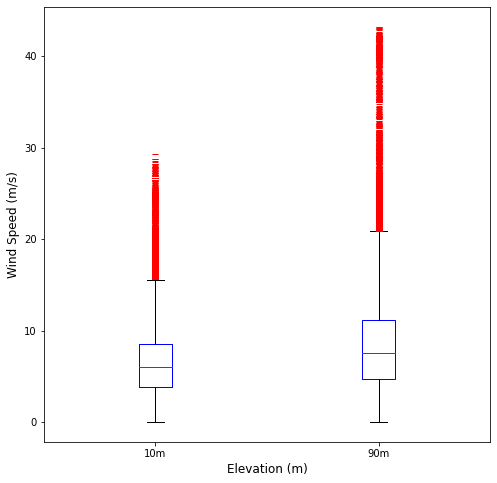

In [21]:
fig, ax = boxplot(data)
fig.set_figheight(8)
fig.set_figwidth(8)

`plot_windrose` generates a windrose plot from the given data. It uses the [windrose](https://github.com/python-windrose/windrose) Python package.

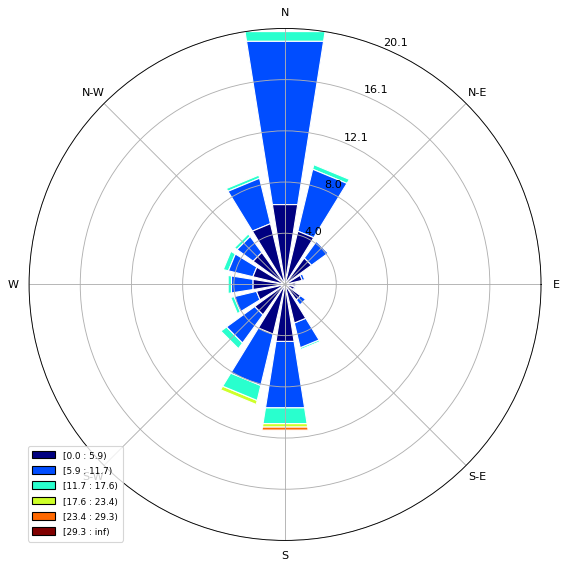

In [11]:
ax = plot_windrose(data)

`pdf` generates a Weibull probability density plot from the given data. It returns `matplotlib` objects as well as parameters representing shape (2), location, and scale for the Weibull distribution.

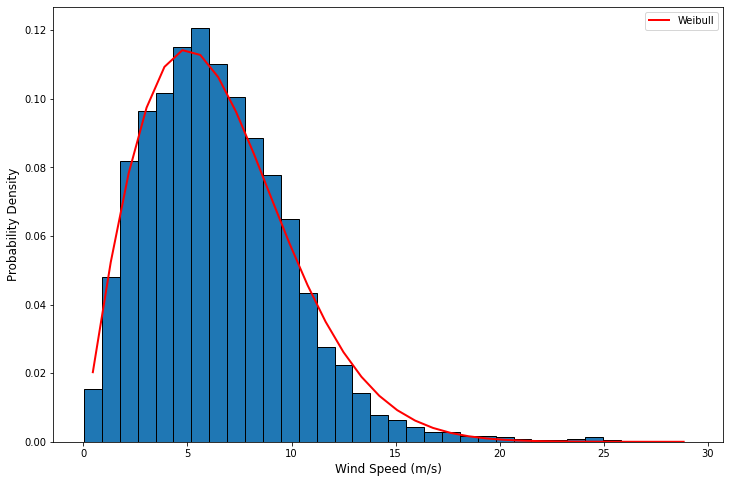

In [26]:
fig, ax, params = pdf(data)
fig.set_figheight(8)
fig.set_figwidth(12)

In [13]:
params

(1, 1.9171141681927462, 0, 7.3048596696897885)

`get_diurnal_stats` returns basic relevant diurnal wind speed statistics for the given data.

In [14]:
get_diurnal_stats(data)

,Mean,Mean+Std,Mean-Std,10th Percentile,Median,90th Percentile
time_index,,,,,,
0,6.802041,10.123861,3.480221,2.760,6.610,10.940
1,6.686356,10.000685,3.372027,2.660,6.350,10.950
2,6.600532,9.875196,3.325868,2.550,6.170,10.921
3,6.514662,9.860482,3.168843,2.610,5.980,10.801
4,6.484610,9.852464,3.116755,2.439,6.005,10.820
5,6.373030,9.806844,2.939216,2.269,6.010,10.640
6,6.325893,9.859768,2.792018,2.040,5.930,10.630
7,6.290025,9.857227,2.722824,1.950,6.050,10.801
8,6.248781,9.825406,2.672156,1.940,5.970,10.890


`plot_diurnal_stats` plots basic relevant diurnal wind speed statistics for the given data.

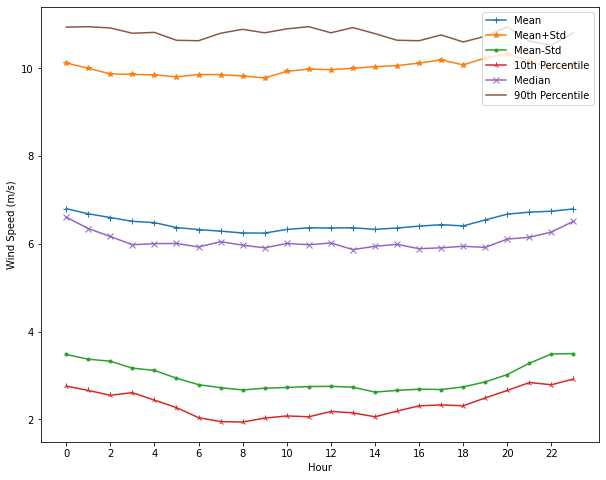

In [29]:
(fig, ax, df) = plot_diurnal_stats(data)
fig.set_figheight(8)
fig.set_figwidth(10)

`turbulence_std` Calculates the turbulence standard deviation. It requires a `WindTurbine` instance, which provides information about the turbulence intensity based on standard wind turbine specifications according to IEC-61400, Section 6.2.

In [16]:
turbine = WindTurbine('II', 'B')
df = turbulence_std(data, turbine)
df

,turbulence_std
time_index,
2007-01-01 00:00:00+00:00,1.129450
2007-01-01 00:10:00+00:00,1.139950
2007-01-01 00:20:00+00:00,1.137850
2007-01-01 00:30:00+00:00,1.126825
2007-01-01 00:40:00+00:00,1.062775
...,...
2007-12-31 23:10:00+00:00,1.620850
2007-12-31 23:20:00+00:00,1.652875
2007-12-31 23:30:00+00:00,1.679125
